<a href="https://colab.research.google.com/github/mostafa-ja/sample/blob/master/Art_Generation_with_Neural_Style_Transfer_v3a_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning & Art: Neural Style Transfer

In this assignment, you will learn about Neural Style Transfer. This algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#from nst_utils import *
import numpy as np
import torchvision
import torch
import torch.nn as nn
from PIL import Image


## 1 - Problem Statement

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 

In this example, you are going to generate an image of the Louvre museum in Paris (content image C), mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S).
<img src="images/louvre_generated.png" style="width:750px;height:200px;">

Let's see how you can do this. 

## 2 - Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [2]:
model = torchvision.models.vgg19(weights=torchvision.models.VGG19_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

## 3 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost





** 3.1.1 - Make generated image G match the content of image C**

#### Shallower versus deeper layers
* The shallower layers of a ConvNet tend to detect lower-level features such as edges and simple textures.
* The deeper layers tend to detect higher-level features such as more complex textures as well as object classes. 

#### Choose a "middle" activation layer $a^{[l]}$
We would like the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the **middle** of the network--neither too shallow nor too deep. 
* (After you have finished this exercise, feel free to come back and experiment with using different layers, to see how the results vary.)

#### Forward propagate image "C"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. (In lecture, we had written this as $a^{[l](C)}$, but here we'll drop the superscript $[l]$ to simplify the notation.) This will be an $n_H \times n_W \times n_C$ tensor.

#### Forward propagate image "G"
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

#### Content Cost Function $J_{content}(C,G)$
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* **Technically this unrolling step isn't needed to compute $J_{content}$, but it will be good practice for when you do need to carry out a similar operation later for computing the style cost $J_{style}$.**


In [3]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1,n_C ,n_H, n_W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1,n_C, n_H, n_W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m,C,H,W = a_G.shape
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = a_C.reshape(C,-1)
    a_G_unrolled = a_G.reshape(C,-1)
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/float(4*C*H*W))*(torch.sum((a_C_unrolled - a_G_unrolled)**2))
    ### END CODE HERE ###
    
    return J_content

In [4]:
a_C = np.array([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866, -1.9202449, 4.6461368, -1.0375276, 4.899456, -7.5360813, 3.4091651, -0.24858844, -2.4324749, 8.146585, -1.7646906, 2.4694333, -6.5859847, 0.7149899, 0.66104376, 4.199985, 2.5062335, 4.5016236, 1.5636368, 3.4233422, -8.455175, 3.4438267, 1.2252892, 0.23202246, 1.4615504, 4.211294, -4.7429867, -2.338422, 1.3776655, -3.3965898, 0.25865, 1.2512636, 7.4767985, 5.1221766, 10.617524, -1.3393097, 0.99052405, -5.4103217, -5.450125, -1.7732203, -4.097825, 4.843958, 2.7449985])
a_C = torch.tensor(a_C.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
a_G = np.array([-0.39043474, -4.965909, -5.387548, 4.572505, 1.1961036, 5.0099816, 1.7304354, -0.13603461, -0.7514645, -3.0110965, 1.0130516, 7.4561086, 0.51901615, -0.23328066, -0.8221154, 0.69788367, 1.5624137, 0.11127031, 3.7990131, -0.5115707, -5.364818, -4.8868036, -1.1914248, -0.12090659, 7.0109277, -1.2259245, 4.2369, -5.399742, 3.159936, 7.259596, 1.643039, 7.3115473, 0.17630118, -2.8375332, 1.839904, -0.71492875, 5.2510543, 1.4054474, 2.8612938, 2.5214956, 4.3172836, 1.902338, 0.14868057, -1.2611487, -0.78171515, 0.5315, -0.8009285, 3.4972606])
a_G = torch.tensor(a_G.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
J_content = compute_content_cost(a_C, a_G)
print(f'J_content = {J_content}')

J_content = 6.765592868805969


Expected Output:

**J_content**	6.765592868805971

#### What you should remember
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When we minimize the content cost later, this will help make sure $G$ has similar content as $C$.

### 3.2 - Computing the style cost




Lets see how you can now define a "style" cost function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature. 
* $G$ is used to denote the Style matrix (or Gram matrix) 
* $G$ also denotes the generated image. 
* For this assignment, we will use $G_{gram}$ to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute $G_{gram}$
In Neural Style Transfer (NST), you can compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

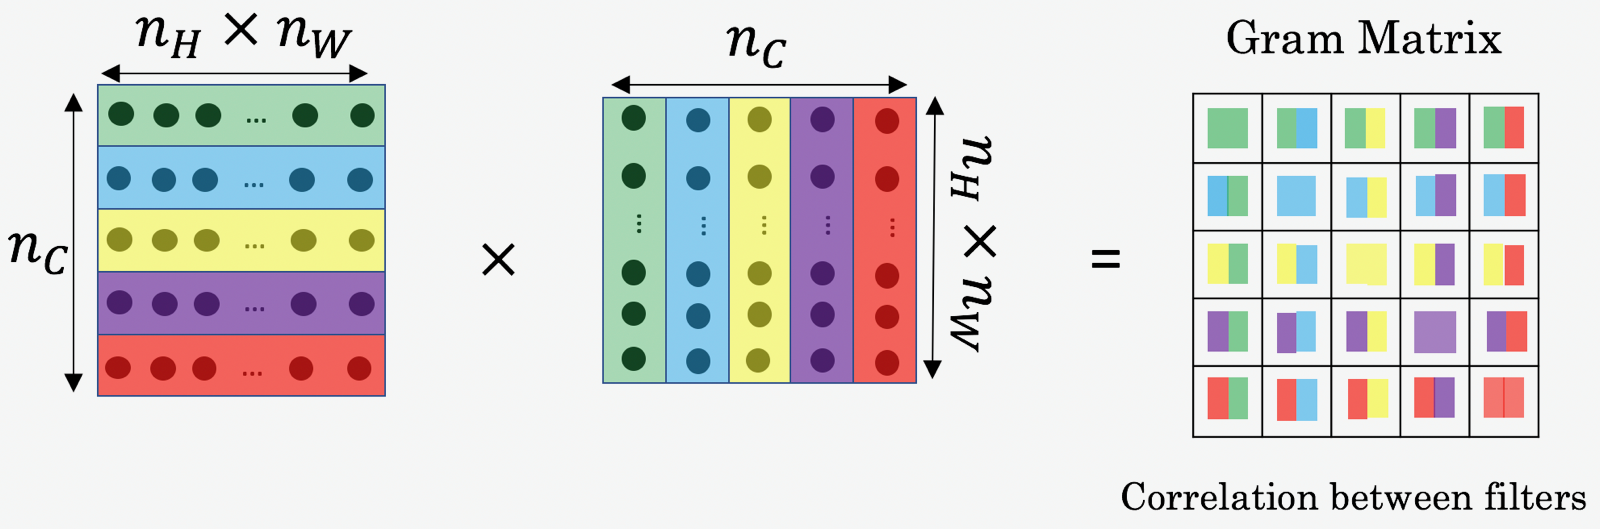

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)i,j}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),i,i}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

In [5]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = torch.matmul(A,torch.transpose(A,0,1))
    ### END CODE HERE ###
    
    return GA

In [6]:
torch.random.manual_seed(1)
A = torch.tensor([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866]).view(3, 2*1)
GA = gram_matrix(A)
print(f'GA =\n {GA}')

GA =
 tensor([[ 6.4223, -4.4291, -2.0967],
        [-4.4291, 19.4658, 19.5639],
        [-2.0967, 19.5639, 20.6865]])


Expected Output:

**GA**	tensor([[ 6.4223, -4.4291, -2.0967]
[ -4.4291, 19.4658, 19.5639]
[ -2.0967, 19.5639, 20.6865]])

### 3.2.2 - Style cost

Your goal will be to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For now, we are using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember, this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


In [7]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m,C,H,W = a_G.shape
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S_unrolled = a_S.reshape(C,-1)
    a_G_unrolled = a_G.reshape(C,-1)

    # Computing gram_matrices for both images S and G (≈2 lines)
    gram_S = gram_matrix(a_S_unrolled)
    gram_G = gram_matrix(a_G_unrolled)
    # Computing the loss (≈1 line)
    J_style_layer = (1/float(4 * (C**2) * (H*W)**2)) * torch.sum((gram_S - gram_G)**2)
    
    ### END CODE HERE ###
    
    return J_style_layer

In [8]:
torch.random.manual_seed(1)
a_S = np.array([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866, -1.9202449, 4.6461368, -1.0375276, 4.899456, -7.5360813, 3.4091651, -0.24858844, -2.4324749, 8.146585, -1.7646906, 2.4694333, -6.5859847, 0.7149899, 0.66104376, 4.199985, 2.5062335, 4.5016236, 1.5636368, 3.4233422, -8.455175, 3.4438267, 1.2252892, 0.23202246, 1.4615504, 4.211294, -4.7429867, -2.338422, 1.3776655, -3.3965898, 0.25865, 1.2512636, 7.4767985, 5.1221766, 10.617524, -1.3393097, 0.99052405, -5.4103217, -5.450125, -1.7732203, -4.097825, 4.843958, 2.7449985])
a_S = torch.tensor(a_S.reshape([1, 4, 4, 3]))
a_G = np.array([-0.39043474, -4.965909, -5.387548, 4.572505, 1.1961036, 5.0099816, 1.7304354, -0.13603461, -0.7514645, -3.0110965, 1.0130516, 7.4561086, 0.51901615, -0.23328066, -0.8221154, 0.69788367, 1.5624137, 0.11127031, 3.7990131, -0.5115707, -5.364818, -4.8868036, -1.1914248, -0.12090659, 7.0109277, -1.2259245, 4.2369, -5.399742, 3.159936, 7.259596, 1.643039, 7.3115473, 0.17630118, -2.8375332, 1.839904, -0.71492875, 5.2510543, 1.4054474, 2.8612938, 2.5214956, 4.3172836, 1.902338, 0.14868057, -1.2611487, -0.78171515, 0.5315, -0.8009285, 3.4972606])
a_G = torch.tensor(a_G.reshape([1, 4, 4, 3]))
J_style_layer = compute_layer_style_cost(a_S, a_G)
print(f'J_style_layer = {J_style_layer}')

J_style_layer = 9.557107667172255


Expected Output:

**J_style_layer**	9.190277771775303


### 3.2.3 Style Weights

* So far you have captured the style from only one layer. 
* We'll get better results if we "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$.
* By default, we'll give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

In [9]:
print(model)
# we choose layers after maxpool 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
style_layers = [0, 5, 10, 19, 28]
style_layer_coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


### Exercise: compute style cost

* We've implemented a compute_style_cost(...) function. 
* It calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 
* Please read over it to make sure you understand what it's doing. 

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style)

Once you're done with the loop:  
* Return the overall style cost.

In [11]:
def compute_style_cost(STYLE_LAYERS, generated_im_results, style_im_results):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_num, coeff in zip(style_layers, style_layer_coeffs):
      # Compute style_cost for the current layer
        a_S = style_im_results[layer_num]
        a_G = generated_im_results[layer_num]
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer



    return J_style



<!-- 
How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers
!-->



## What you should remember
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- We get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 



### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

**Exercise**: Implement the total cost function which includes both the content cost and the style cost. 

In [12]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J


## What you should remember
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

## 4 - Solving the optimization problem

In [13]:
!wget 'https://github.com/mostafa-ja/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet.jpg'

--2022-08-26 23:21:07--  https://github.com/mostafa-ja/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet.jpg [following]
--2022-08-26 23:21:08--  https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/monet.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

In [14]:
!wget 'https://github.com/mostafa-ja/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre_small.jpg'

--2022-08-26 23:21:09--  https://github.com/mostafa-ja/coursera-deep-learning-specialization/raw/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre_small.jpg
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre_small.jpg [following]
--2022-08-26 23:21:09--  https://raw.githubusercontent.com/mostafa-ja/coursera-deep-learning-specialization/master/C4%20-%20Convolutional%20Neural%20Networks/Week%204/Neural%20Style%20Transfer/images/louvre_small.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)

In [15]:
import imageio

imsize = 300
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Resize((imsize,imsize)),
                                              ])

def load_image(image_address):
  image = imageio.imread(image_address)
  image = transformer(image)
  image = image.unsqueeze(0)  #Returns a new tensor with a dimension of size one inserted at first 
  return image                # (c,h,w)to(1,c,h,w) because in optimization must have m as batch_size

#### Content image
Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [16]:
content_image = load_image("/content/louvre_small.jpg")
print(content_image.shape)


torch.Size([1, 3, 300, 300])


#### Style image
Let's load, reshape and normalize our "style" image (Claude Monet's painting):

torch.Size([1, 3, 300, 300])


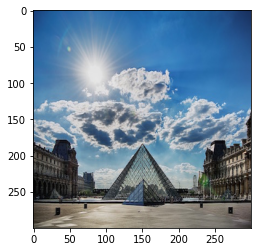

In [17]:
style_image = load_image("/content/monet.jpg")
print(content_image.shape)
plt.imshow(content_image.permute(0,2,3,1)[0]); #permute to change C and [0] to remove m dimension

#### Generated image correlated with content image
Now, we initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 


In [18]:
def generate_noise_image(content_image,noise_ratio=0.6):
  """
    Generates a noisy image by adding random noise to the content_image
  """
# torch.rand() : Returns a tensor filled with random numbers from a uniform distribution on the interval [0, 1)
  noise_image = torch.rand(content_image.shape,dtype=torch.float32)
  output = noise_image * noise_ratio + content_image * (1-noise_ratio)

  return output

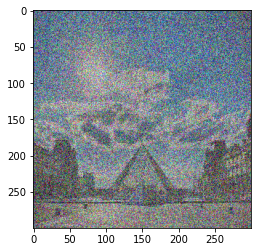

In [19]:
generated_image = generate_noise_image(content_image).requires_grad_(True)
plt.imshow(generated_image.detach().permute(0,2,3,1)[0]);

#### Load pre-trained VGG19 model
Next, as explained in part (2), let's load the VGG19 model.

In [20]:
list(model.features[:4])

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True)]

In [21]:
import torchvision.models as models

class VGG19_StyleTransfer(nn.Module):
  def __init__(self,chosen_layers):
    super().__init__()
    self.chosen_layers = chosen_layers
    layers_needed = max(chosen_layers)+1
    features =list(models.vgg19(weights=models.VGG19_Weights.DEFAULT).features[:layers_needed])
    self.features = nn.ModuleList(features).eval() #use nn.ModuleList instead of python list for cuda error

  def forward(self,x):
    results = {}
    for layer_num , module in enumerate(self.features):
      x = module(x)
      if layer_num in self.chosen_layers :
        results[layer_num] = x
    
    return results


In [22]:
from torchvision.models.vgg import VGG19_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

style_layers = [0, 5, 10, 19, 28]
style_layer_coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]

content_layer = 21
model = VGG19_StyleTransfer(style_layers + [content_layer]).to(device)
content_image = content_image.to(device)
style_image = style_image.to(device)
generated_image = torch.tensor(generated_image).float().to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [23]:
optimizer = torch.optim.Adam([generated_image.requires_grad_()],lr=0.1)

content_image_features = model(content_image)
style_image_features = model(style_image)

In [24]:
content_image_features.keys()

dict_keys([0, 5, 10, 19, 21, 28])

In [25]:
# remove content_image_features & style_image_features from computation graph
for layer in content_image_features.keys():
  content_image_features[layer] = content_image_features[layer].detach()
  style_image_features[layer] = style_image_features[layer].detach()

In [32]:
def train(model,content_image_features,style_image_features,content_layer,style_layers,style_layer_coeffs,generated_image,num_iterations=200):
  for i in range(num_iterations):
    generated_image_feature = model(generated_image)
    a_G = generated_image_feature[content_layer]
    a_C = content_image_features[content_layer]
    J_content = compute_content_cost(a_C,a_G)
    J_style = compute_style_cost(style_layers,generated_image_feature,style_image_features)

    optimizer.zero_grad()
    Jt = total_cost(J_content,J_style)
    Jt.backward()
    optimizer.step()
    
    if i % 20 ==0:
      print("Iteration " + str(i) + " :")
      print("total cost = " + str(Jt.item()))
      print("content cost = " + str(J_content.item()))
      print("style cost = " + str(J_style.item()))

      save_image('/content/A/'+str(i)+'.jpg',generated_image)

  save_image('/content/A/generated_image.jpg', generated_image)



In [31]:
def save_image(path,image):
  image = image.detach().cpu().numpy().transpose(0,2,3,1)  # .cpu() : Use Tensor.cpu() to copy the tensor to host memory first.
  image = image.astype('uint8')
  imageio.imsave(path,image[0])

In [28]:
params = {
    'model': model,
    'style_layers': style_layers,
    'style_layer_coeffs': style_layer_coeffs,
    'content_layer': content_layer,
    'generated_image': generated_image,
    'content_image_features': content_image_features,
    'style_image_features': style_image_features
}

In [33]:
train(**params,num_iterations=500)

Iteration 0 :
total cost = 3.584775924682617
content cost = 0.2002854198217392
style cost = 0.03954804688692093
Iteration 20 :
total cost = 4.302022933959961
content cost = 0.21912860870361328
style cost = 0.05276842787861824
Iteration 40 :
total cost = 5.596168518066406
content cost = 0.2694670557975769
style cost = 0.07253745198249817
Iteration 60 :
total cost = 5.51634407043457
content cost = 0.26335856318473816
style cost = 0.0720689669251442
Iteration 80 :
total cost = 4.710053443908691
content cost = 0.22408530116081238
style cost = 0.06173000484704971
Iteration 100 :
total cost = 3.4190011024475098
content cost = 0.17734751105308533
style cost = 0.041138146072626114
Iteration 120 :
total cost = 4.927463531494141
content cost = 0.24520836770534515
style cost = 0.06188449636101723
Iteration 140 :
total cost = 3.7564048767089844
content cost = 0.19207711517810822
style cost = 0.045890845358371735
Iteration 160 :
total cost = 3.4974093437194824
content cost = 0.1939382553100586
styl

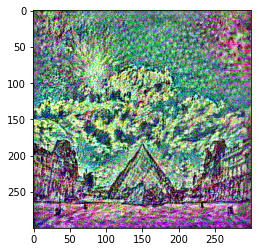

In [34]:
plt.imshow(generated_image.cpu().detach().permute(0,2,3,1)[0]);

## 5 - Test with your own image (Optional/Ungraded)

Finally, you can also rerun the algorithm on your own images! 

To do so, go back to part 4 and change the content image and style image with your own pictures. In detail, here's what you should do:

1. Click on "File -> Open" in the upper tab of the notebook
2. Go to "/images" and upload your images (requirement: (WIDTH = 300, HEIGHT = 225)), rename them "my_content.png" and "my_style.png" for example.
3. Change the code in part (3.4) from :
```python
content_image = scipy.misc.imread("images/louvre.jpg")
style_image = scipy.misc.imread("images/claude-monet.jpg")
```
to:
```python
content_image = scipy.misc.imread("images/my_content.jpg")
style_image = scipy.misc.imread("images/my_style.jpg")
```
4. Rerun the cells (you may need to restart the Kernel in the upper tab of the notebook).

You can share your generated images with us on social media with the hashtag #deeplearniNgAI or by direct tagging!

You can also tune your hyperparameters: 
- Which layers are responsible for representing the style? STYLE_LAYERS
- How many iterations do you want to run the algorithm? num_iterations
- What is the relative weighting between content and style? alpha/beta

## 6 - Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

## What you should remember
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




# Congratulations on finishing the course!
This was the final programming exercise of this course. Congratulations--you've finished all the programming exercises of this course on Convolutional Networks! We hope to also see you in Course 5, on Sequence models! 


### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
